In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy import units as u
from scipy import interpolate
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Rectangle
from scipy.stats import pearsonr, spearmanr

In [2]:
dirs = ['7-20211101-20220619/']#,'6-20200915-20210503/','4-20180918-20190528/','3B-20180206-20180622/','8-20220818-20230223/','1-20150918-20160527/','2-20160913-20170615/','3A-20170919-20180123/','5-20190928-20200608/']
dirs.sort()
# dir = 'all-20150918-20230223/'
# dir = '8-20220818-20230223/'
# lc_file_path = 'Output/Light_curve_001/4fgl_j0854.8+2006_lightcurve.fits'
# emin = 0.1 *u.GeV
# emax = 300 *u.GeV
# D_l = 1588.6 *u.Mpc
# hdul = fits.open('./' + dir+lc_file_path)
# lc = hdul[1].data

In [3]:
rmagdat = pd.read_csv('./apjlad4d9bt1_mrt.txt', sep='\s+', header=None, skiprows=25, names=['HJD', 'Rmag', 'e_Rmag', 'NPTS'])


#convert Rmag to flux

# m1 - m2 = -2.5 log10(f1/f2)
# m2 = 0; f2 = 3.08 * 10**-20 erg/cm^2/s

f2 = 3.08 * 10**-20 * (u.erg/u.cm**2/u.s)
f2 = f2.to(u.MeV/u.cm**2/u.d)

f1 = (10**(rmagdat['Rmag'].values + 2.5)) * f2
f1_err = (10**(rmagdat['e_Rmag'] + 2.5)) * f2


In [4]:
tt = rmagdat['HJD'].values - 2400000.5
idx = []
for i in range(len(tt)):
    if tt[i] <= 59800 and tt[i] >= 59500:
        idx.append(i)

/tmp/ipykernel_3615/1805507762.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(0, 1.1, 0.2).round(2), fontdict={'size': 14, 'weight': 'bold'})
/tmp/ipykernel_3615/1805507762.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.arange(0, 1.1, 0.2).round(2), fontdict={'size': 14, 'weight': 'bold'})
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2, 11)


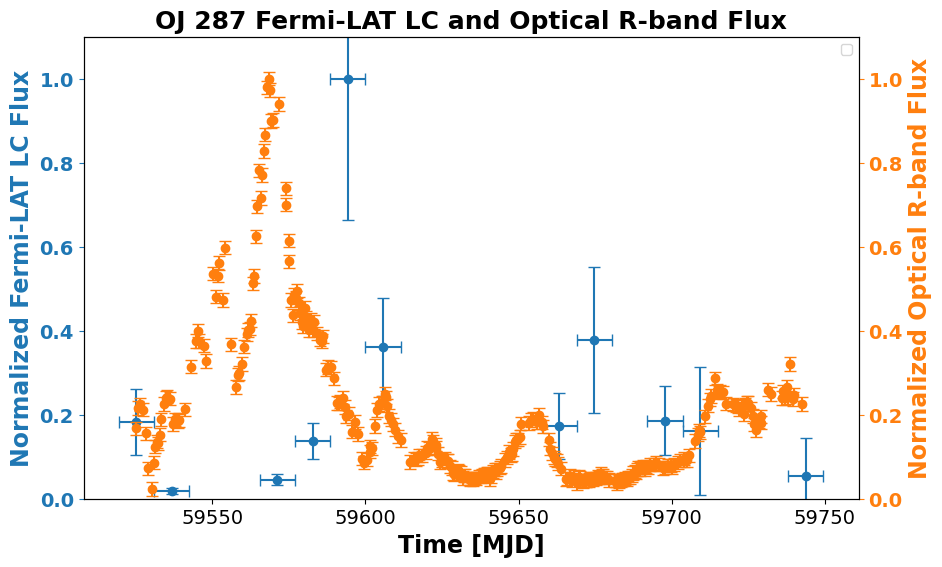

In [12]:
TSmin = 9

dir = dirs[0]
lc_file_path = 'Output/Light_curve_001/4fgl_j0854.8+2006_lightcurve.fits'
emin = 0.1 *u.GeV
emax = 300 *u.GeV
D_l = 1588.6 *u.Mpc
hdul = fits.open('./' + dir+lc_file_path)
lc = hdul[1].data
if len(lc['flux']) > 0:
    scale = int(np.log10(lc['flux'].max())) -2
else:
    scale = int(np.log10(lc['flux_ul95'].max())) -2
    
tmean = (lc['tmin_mjd'] + lc['tmax_mjd'])/2


# find the nearest element in x_rmag for each element in x_lc
lcx = np.argwhere(lc['ts'] > TSmin)
x_lc = tmean[lc['ts'] > 9]
xl_lc = lc['tmin_mjd'][lc['ts'] > 9]
xr_lc = lc['tmax_mjd'][lc['ts'] > 9]

print(np.shape([x_lc - xl_lc, xr_lc - x_lc]))

x_lc = np.array(tmean[lcx]).flatten()
xl_lc = np.array(lc['tmin_mjd'][lcx]).flatten()
xr_lc = np.array(lc['tmax_mjd'][lcx]).flatten()
y_lc = np.array(lc['flux'])[lcx]/max(lc['flux'][lcx]).flatten()
yerr_lc = np.array(lc['flux_err'])[lcx]/max(lc['flux'][lcx]).flatten()


y_lc = np.array(lc['flux'])[lc['ts'] > 9]/max(lc['flux'])
yerr_lc = np.array(lc['flux_err'])[lc['ts'] > 9]/max(lc['flux'] + max(lc['flux_err']))

x_rmag = np.subtract(rmagdat['HJD'], 2400000.5)
y_rmag = f1
y_err_rmag = f1_err
x_rmag_cb = x_rmag[idx[0]:idx[-1]]
y_rmag_cb = y_rmag[idx[0]:idx[-1]]
y_err_rmagb = y_err_rmag[idx[0]:idx[-1]]
idx = np.zeros(len(x_lc), dtype=int)
for i in range(len(x_lc)):
    idx[i] = np.abs(x_rmag - x_lc[i]).argmin()
   

x_rmag_c = x_rmag[idx]
y_rmag_c = y_rmag[idx]
y_err_rmag = y_err_rmag[idx]


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.xlabel('Time [MJD]', fontdict={'size': 17, 'weight': 'bold'})
plt.xticks(fontsize=14)
ax2 = ax.twinx()

ax.errorbar(x_lc, y_lc/max(y_lc), yerr=yerr_lc/max(y_lc), xerr=[x_lc - xl_lc, xr_lc - x_lc], c='C0', fmt='o', capsize=4, label='Fermi-LAT LC')
# ax.plot(x_lc, y_lc/max(y_lc), c='C0', lw=0.2)
ax.set_yticklabels(np.arange(0, 1.1, 0.2).round(2), fontdict={'size': 14, 'weight': 'bold'})
TSmin=9




ax2.errorbar(x_rmag_cb, y_rmag_cb/max(y_rmag_cb), yerr=y_err_rmagb/max(y_rmag_cb),  c='C1', fmt='o', capsize=4)
# ax2.errorbar(x_rmag_c, y_rmag_c/max(y_rmag_c), yerr=y_err_rmag/max(y_rmag_c),xerr=[tmean[lc['ts']>TSmin]- lc['tmin_mjd'][lc['ts']>TSmin], lc['tmax_mjd'][lc['ts']>TSmin] - tmean[lc['ts']>TSmin]], c='C2', fmt='o', capsize=4)

# ax2.vlines(59531.5, 0, 1.2, color='red', linestyle='--', label='Nov 12 2021')

# ax2.plot(x_rmag_c, y_rmag_c/max(y_rmag_c), c='C1', lw=0.2)
ax.set_ylabel('Normalized Fermi-LAT LC Flux', color='C0', fontdict={'size': 17, 'weight': 'bold'})
ax2.set_ylabel('Normalized Optical R-band Flux', color='C1', fontdict={'size': 17, 'weight': 'bold'})    
ax2.set_yticklabels(np.arange(0, 1.1, 0.2).round(2), fontdict={'size': 14, 'weight': 'bold'})
ax.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
ax.tick_params(axis='y', colors='C0', labelcolor='C0')
ax2.tick_params(axis='y', colors='C1', labelcolor='C1')

# ax2.set_xlabel('Time [MJD]')
# plt.xlabel('Time [MJD]')
ax2.legend()
plt.title('OJ 287 Fermi-LAT LC and Optical R-band Flux', fontdict={'size': 18, 'weight': 'bold'})
# plt.show()
plt.savefig('./temp/OJ287_LC_R_band.pdf', dpi=300, facecolor='w', edgecolor='w', format='pdf')

In [6]:
tmean[lcx].flatten()

array([59525.25075444, 59536.75075444, 59571.25075444, 59582.75075444,
       59594.25075444, 59605.75075444, 59663.25075444, 59674.75075444,
       59697.75075444, 59709.25075444, 59743.75075444])

In [38]:
print(np.round(pearsonr(y_lc/max(y_lc), y_rmag_c/max(y_rmag_c)), 3))
print(np.round(spearmanr(y_lc/max(y_lc), y_rmag_c/max(y_rmag_c)), 3))

[-0.265  0.43 ]
[-0.645  0.032]


In [8]:
# fig = plt.figure(figsize=(10, 6))
# fig, ax = plt.subplots(figsize=(10, 6))
# plt.errorbar(np.subtract(rmagdat['HJD'], 2400000.5), rmagdat['Rmag'], yerr=rmagdat['e_Rmag'], fmt='.', color='black', label='R-band')

# ax.plot(np.subtract(rmagdat['HJD'], 2400000.5) * u.d, 1e10*f1, marker='x', lw=0.2, label='Optical R-band')
# ax.plot(np.subtract(rmagdat['HJD'], 2400000.5) * u.d, f1/max(f1[idx]), marker='x', lw=0.2, label='Optical R-band')


TSmin = 9
################################################
########## LC energy flux
################################################


# ax2 = ax.twinx()
# xaa=0
# for dir in dirs:
dir = dirs[0]
lc_file_path = 'Output/Light_curve_001/4fgl_j0854.8+2006_lightcurve.fits'
emin = 0.1 *u.GeV
emax = 300 *u.GeV
D_l = 1588.6 *u.Mpc
hdul = fits.open('./' + dir+lc_file_path)
lc = hdul[1].data
if len(lc['flux']) > 0:
    scale = int(np.log10(lc['flux'].max())) -2
else:
    scale = int(np.log10(lc['flux_ul95'].max())) -2
    
tmean = (lc['tmin_mjd'] + lc['tmax_mjd'])/2
#     xaa = lc['tmin_mjd'].min()
#     # ax2.errorbar(tmean, (10**(-scale))*lc['flux'], xerr = [ tmean- lc['tmin_mjd'], lc['tmax_mjd'] - tmean ], yerr=(10**-scale)*lc['flux_err'], fmt='o', capsize=4, c='C1')
#     # ax2.plot(tmean, (10**(-scale))*lc['flux'], c='C1', lw=0.2)
#     ax2.errorbar(tmean, lc['flux']/max(lc['flux']), xerr = [ tmean- lc['tmin_mjd'], lc['tmax_mjd'] - tmean ], yerr=lc['flux_err']/(max(lc['flux'])), fmt='o', capsize=4, c='C1')
#     ax2.plot(tmean, lc['flux']/max(lc['flux']), c='C1', lw=0.2)
#     # ax2.add_patch(Rectangle((lc['tmin_mjd'].min(), -0.5), max(lc['tmax_mjd']) - min(lc['tmin_mjd']), 1 , alpha=0.5))
# # plt.errorbar(tmean[lc['ts']<=TSmin], (10**-scale)*lc['flux_ul95'][lc['ts']<=TSmin], xerr = [ tmean[lc['ts']<=TSmin]- lc['tmin_mjd'][lc['ts']<=TSmin], lc['tmax_mjd'][lc['ts']<=TSmin] - tmean[lc['ts']<=TSmin] ], yerr=10**(-scale ) * np.abs(lc['flux_err'][lc['ts']<=TSmin]), markeredgecolor='black', fmt='o', uplims=True, color='orange', capsize=4)

# ax.vlines(59531.5, 0,1, color='red', linestyle='--', label='Nov 12 2021')
# ax.set_ylabel('NORM R-band Flux $\\times$ 10$^{-10}$ MeV cm$^{-2}$ s$^{-1}$')
# ax.set_ylim(0, 1.1)
# ax2.set_ylim(0, 1.1)
# ax2.set_ylabel('NORM $\gamma$ ray Flux $\\times$ 10$^{'+str(scale)+'}$ MeV cm$^{-2}$ s$^{-1}$', color='C1')
# ax2.tick_params(axis='y', color='C1', labelcolor='C1')
# plt.xlim(59500, 59800)
# # ax.legend(loc='upper right')
# plt.grid(which='both')
# # ax2.legend()

In [9]:
(tmean[np.argmax(lc['flux'])], np.subtract(rmagdat['HJD'], 2400000.5)[np.argmax(f1)], 59531)

(59594.250754444445, 55455.13151999982, 59531)

In [10]:
lc['flux']

array([2.67234204e-08, 2.58766120e-09, 1.02133153e-08, 5.87991469e-09,
       6.65461535e-09, 2.02028771e-08, 1.45928848e-07, 5.27407162e-08,
       1.31547894e-08, 3.22948113e-13, 1.99537271e-08, 7.85619030e-09,
       2.52881983e-08, 5.50696232e-08, 5.92446228e-09, 2.71097687e-08,
       2.36114052e-08, 1.56215416e-08, 3.70790804e-09, 7.92453580e-09],
      dtype='>f8')

In [11]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.interpolate import interp1d

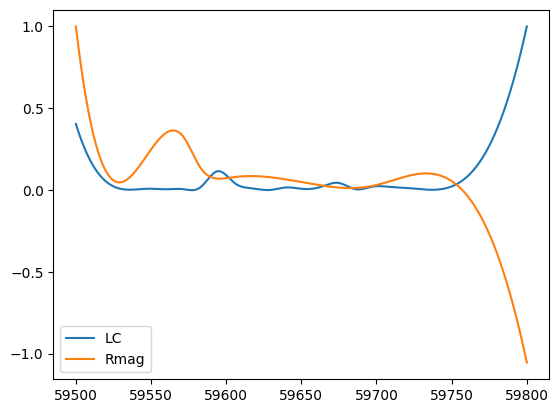

In [12]:
x_lc = tmean
y_lc = np.array(lc['flux'])#/max(lc['flux']))
x_rmag = np.subtract(rmagdat['HJD'], 2400000.5)[idx]
y_rmag = f1[idx]#/max(f1[idx])

# f_lc = interp1d(x_lc, y_lc, kind='cubic', fill_value='extrapolate')
# f_rmag = interp1d(x_rmag, y_rmag, kind='cubic', fill_value='extrapolate')

lc_tck = interpolate.splrep(x_lc, y_lc, k=3)
rmag_tck = interpolate.splrep(x_rmag, y_rmag, k=3)

x =  np.linspace(59500, 59800, 1000)

f_lc = interpolate.splev(x, lc_tck)
f_rmag = interpolate.splev(x, rmag_tck)

plt.figure()
plt.plot(x, f_lc/max(f_lc), label='LC')
plt.plot(x, f_rmag/max(f_rmag), label='Rmag')
plt.legend()
plt.show()

In [13]:
pearsonr(f_lc, f_rmag)

PearsonRResult(statistic=-0.6848405832682378, pvalue=2.4302368316444683e-139)

In [14]:
if_lc = interpolate.interp1d(x_lc, y_lc, kind='cubic', fill_value='extrapolate')
if_rmag = interpolate.interp1d(x_rmag, y_rmag, kind='cubic', fill_value='extrapolate')
y_lc_interp = if_lc(x)
y_rmag_interp = if_rmag(x)

pearsonr(y_lc_interp, y_rmag_interp)

PearsonRResult(statistic=-0.6848405832682377, pvalue=2.430236831645168e-139)

In [15]:
np.array(lc['flux_err'])[lc['ts'] > 9]

array([1.74387849e-08, 1.63113293e-09, 3.01450757e-09, 9.43119644e-09,
       7.42924530e-08, 2.58467481e-08, 1.72666976e-08, 3.82613286e-08,
       1.82413191e-08, 3.36788568e-08, 1.98245674e-08], dtype='>f8')

In [16]:
y_lc

array([2.67234204e-08, 2.58766120e-09, 1.02133153e-08, 5.87991469e-09,
       6.65461535e-09, 2.02028771e-08, 1.45928848e-07, 5.27407162e-08,
       1.31547894e-08, 3.22948113e-13, 1.99537271e-08, 7.85619030e-09,
       2.52881983e-08, 5.50696232e-08, 5.92446228e-09, 2.71097687e-08,
       2.36114052e-08, 1.56215416e-08, 3.70790804e-09, 7.92453580e-09],
      dtype='>f8')

In [17]:
np.array(lc['flux'])[lc['ts'] > 9]

array([2.67234204e-08, 2.58766120e-09, 6.65461535e-09, 2.02028771e-08,
       1.45928848e-07, 5.27407162e-08, 2.52881983e-08, 5.50696232e-08,
       2.71097687e-08, 2.36114052e-08, 7.92453580e-09], dtype='>f8')

PearsonRResult(statistic=-0.13420556263949712, pvalue=0.5726846260449145)
SignificanceResult(statistic=-0.2721804511278195, pvalue=0.24566887828037737)


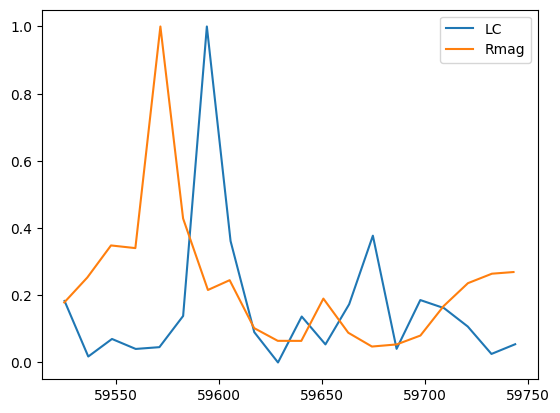

In [18]:
# find the nearest element in x_rmag for each element in x_lc

x_lc = tmean
y_lc = np.array(lc['flux'])/max(lc['flux'])
yerr_lc = np.array(lc['flux_err'])/max(lc['flux'])
y_UL_lc = np.array(lc['flux_ul95'])[lc['ts'] <= 9]/max(lc['flux'])
yerr_UL_lc = np.array(lc['flux_err'])[lc['ts'] <= 9]/max(lc['flux'])
x_rmag = np.subtract(rmagdat['HJD'], 2400000.5)
y_rmag = f1
idx = np.zeros(len(x_lc), dtype=int)
for i in range(len(x_lc)):
    idx[i] = np.abs(x_rmag - x_lc[i]).argmin()
   

x_rmag_c = x_rmag[idx]
y_rmag_c = y_rmag[idx]


plt.figure()
plt.plot(x_lc, y_lc/max(y_lc), label='LC')
plt.plot(x_rmag_c, y_rmag_c/max(y_rmag_c), label='Rmag')
plt.legend()
print(pearsonr(y_lc/max(y_lc), y_rmag_c/max(y_rmag_c)))
print(spearmanr(y_lc/max(y_lc), y_rmag_c/max(y_rmag_c)))